# Análise de Consumo de Álcool por País

Este notebook analisa os dados de consumo de álcool **por pessoa** em diferentes países no ano de 2010, incluindo cerveja, destilados e vinho.

**Unidades:** Doses médias por pessoa (beer_servings, spirit_servings, wine_servings) e litros de álcool puro por pessoa por ano (total_litres_of_pure_alcohol).

**Fonte:** FiveThirtyEight, _"Dear Mona Followup: Where Do People Drink The Most Beer, Wine And Spirits?"_, 2014; World Health Organisation, 2010; Global Information System on Alcohol and Health (GISAH), 2010.

## Objetivos, perguntas e hipóteses

- **Objetivo principal:** explorar padrões globais de consumo de álcool per capita e identificar quais tipos de bebida mais explicam o consumo total.
- **Perguntas-chave:**
  - Quais regiões concentram os maiores e menores consumos per capita?
  - Países de maioria islâmica consomem significativamente menos álcool? (Hipótese I)
  - Entre beer, wine e spirits, qual variável explica melhor o consumo total? (Hipótese II)
- **Escopo analítico:** EDA, testes de hipótese, modelos preditivos (regressão e classificação), métricas, tuning e recomendações.
- **Observação temporal:** dados de 2010 (base estática, sem série temporal).

## Dados e licença

- **Fonte:** FiveThirtyEight (artigo "Dear Mona Followup: Where Do People Drink The Most Beer, Wine And Spirits?", 2014) + WHO/GISAH 2010. Licença FiveThirtyEight (MIT-like) + uso educacional.
- **Granularidade (nível de extensão dos dados):** país (2010); unidades per capita.
- **Uso previsto:** EDA, testes de hipótese e modelos simples para fins didáticos; não há identificação pessoal (dados agregados).

## 1. Importação de Bibliotecas

Para visualizações geográficas, utilizaremos também o **plotly** que permite criar mapas interativos.

In [ ]:
!pip install pandas seaborn matplotlib plotly numpy scipy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor


## 2. Carregamento dos Dados

In [ ]:
df_drinks = pd.read_csv("drinks.csv")

## 3. Reconhecimento e Exploração dos Dados


In [ ]:
df_drinks.head()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
0,Afghanistan,0,0,0,0.0
1,Albania,89,132,54,4.9
2,Algeria,25,0,14,0.7
3,Andorra,245,138,312,12.4
4,Angola,217,57,45,5.9


In [ ]:
df_drinks

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
0,Afghanistan,0,0,0,0.0
1,Albania,89,132,54,4.9
2,Algeria,25,0,14,0.7
3,Andorra,245,138,312,12.4
4,Angola,217,57,45,5.9
...,...,...,...,...,...
188,Venezuela,333,100,3,7.7
189,Vietnam,111,2,1,2.0
190,Yemen,6,0,0,0.1
191,Zambia,32,19,4,2.5


In [ ]:
df_drinks.isna().sum()

country                         0
beer_servings                   0
spirit_servings                 0
wine_servings                   0
total_litres_of_pure_alcohol    0
dtype: int64

In [ ]:
df_drinks.duplicated().sum()

np.int64(0)

In [ ]:
df_drinks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       193 non-null    object 
 1   beer_servings                 193 non-null    int64  
 2   spirit_servings               193 non-null    int64  
 3   wine_servings                 193 non-null    int64  
 4   total_litres_of_pure_alcohol  193 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 7.7+ KB


In [ ]:
df_drinks.describe()

,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
count,193.000000,193.000000,193.000000,193.000000
mean,106.160622,80.994819,49.450777,4.717098
std,101.143103,88.284312,79.697598,3.773298
min,0.000000,0.000000,0.000000,0.000000
25%,20.000000,4.000000,1.000000,1.300000
50%,76.000000,56.000000,8.000000,4.200000
75%,188.000000,128.000000,59.000000,7.200000
max,376.000000,438.000000,370.000000,14.400000


In [ ]:
numeric_cols = df_drinks.select_dtypes(include=[np.number]).columns
df_numeric = df_drinks[numeric_cols]

Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = ((df_numeric < limite_inferior) | (df_numeric > limite_superior)).sum()
outliers


beer_servings                    0
spirit_servings                  5
wine_servings                   26
total_litres_of_pure_alcohol     0
dtype: int64

In [ ]:
df_drinks.sort_values(by="total_litres_of_pure_alcohol", ascending=False).head()

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol
15,Belarus,142,373,42,14.4
98,Lithuania,343,244,56,12.9
3,Andorra,245,138,312,12.4
68,Grenada,199,438,28,11.9
61,France,127,151,370,11.8


## 4. Tratamento e Transformação de Dados

### 4.1 Criação de Categorias de Consumo

Criação de uma variável categórica para classificar os países de acordo com o nível de consumo de **ÁLCOOL PURO POR PESSOA**
(Utilizando como corte os valores nos **quartis** da amostra de dados).

**Critérios de categorização (litros/ano por pessoa):**
- **Very Low**: 0 - 1 litro/ano
- **Low**: 1 - 4 litros/ano
- **Medium**: 4 - 7 litros/ano
- **High**: 7 - 10 litros/ano
- **Very High**: acima de 10 litros/ano

In [ ]:
bins = [0, 1, 4, 7, 10, float('inf')]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

df_drinks['consumption_category'] = pd.cut(df_drinks['total_litres_of_pure_alcohol'], bins=bins, labels=labels, include_lowest=True)

In [ ]:
df_drinks['consumption_category'].value_counts().sort_index()

consumption_category
Very Low     44
Low          48
Medium       50
High         26
Very High    25
Name: count, dtype: int64

### 4.2 Verificação da Distribuição das Categorias

In [ ]:
df_drinks

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,consumption_category
0,Afghanistan,0,0,0,0.0,Very Low
1,Albania,89,132,54,4.9,Medium
2,Algeria,25,0,14,0.7,Very Low
3,Andorra,245,138,312,12.4,Very High
4,Angola,217,57,45,5.9,Medium
...,...,...,...,...,...,...
188,Venezuela,333,100,3,7.7,High
189,Vietnam,111,2,1,2.0,Low
190,Yemen,6,0,0,0.1,Very Low
191,Zambia,32,19,4,2.5,Low


## 5. Análise Exploratória Visual (EDA Gráfica)

Análise visual da distribuição do consumo de bebidas alcoólicas e possíveis padrões entre as variáveis.



### 5.1 Mapa-Múndi de Categorias de Consumo de Álcool

Visualização geográfica das categorias de consumo de álcool **por pessoa** por país. O mapa utiliza um esquema de cores para representar as diferentes faixas de consumo per capita.

In [ ]:
category_order = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
df_drinks['category_numeric'] = df_drinks['consumption_category'].cat.codes

fig = px.choropleth(
    df_drinks,
    locations="country",
    locationmode='country names',
    color="consumption_category",
    hover_name="country",
    hover_data={
        'total_litres_of_pure_alcohol': ':.2f',
        'beer_servings': True,
        'wine_servings': True,
        'spirit_servings': True,
        'consumption_category': True,
        'category_numeric': False
    },
    color_discrete_sequence=px.colors.sequential.Reds,
    category_orders={'consumption_category': category_order},
    title='Categorias de Consumo de Álcool por País (2010) - Per Capita',
    labels={
        'consumption_category': 'Categoria de Consumo',
        'total_litres_of_pure_alcohol': 'Litros de Álcool Puro/Ano (por pessoa)',
        'beer_servings': 'Doses de Cerveja (por pessoa)',
        'wine_servings': 'Doses de Vinho (por pessoa)',
        'spirit_servings': 'Doses de Destilados (por pessoa)'
    }
)

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    ),
    height=600,
    width=1000
)

fig.show()

C:\Users\pedro.henrique\AppData\Local\Temp\ipykernel_5644\2509732315.py:4: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



### 5.2 Mapa-Múndi de Consumo Total de Álcool (Escala Contínua)

Visualização alternativa mostrando o consumo total de álcool puro **por pessoa** em uma escala de cores contínua, permitindo identificar nuances na distribuição geográfica do consumo per capita.

In [ ]:
fig2 = px.choropleth(
    df_drinks,
    locations="country",
    locationmode='country names',
    color="total_litres_of_pure_alcohol",
    hover_name="country",
    hover_data={
        'total_litres_of_pure_alcohol': ':.2f',
        'beer_servings': True,
        'wine_servings': True,
        'spirit_servings': True,
        'consumption_category': True
    },
    color_continuous_scale='Reds',
    title='Consumo Total de Álcool Puro por País (2010) - Litros/Ano Per Capita',
    labels={
        'total_litres_of_pure_alcohol': 'Litros/Ano (por pessoa)',
        'beer_servings': 'Doses de Cerveja (por pessoa)',
        'wine_servings': 'Doses de Vinho (por pessoa)',
        'spirit_servings': 'Doses de Destilados (por pessoa)'
    }
)

fig2.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    ),
    height=600,
    width=1000
)

fig2.show()

C:\Users\pedro.henrique\AppData\Local\Temp\ipykernel_5644\1554864097.py:1: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



**Interpretação:**

Os mapas geográficos apresentados revelam padrões claros e regionais no consumo de álcool per capita ao redor do mundo. Países da Europa Central, Oriental e Rússia destacam-se com os maiores níveis de consumo, enquanto regiões do Oriente Médio, Norte da África e partes da Ásia apresentam os menores índices, refletindo influências culturais e religiosas.

- Alguns países aparecem sem preenchimento no mapa devido à ausência de dados no conjunto utilizado, impossibilitando a estimativa do consumo anual de álcool nessas regiões.
- O elevado consumo de álcool na Europa Central, Oriental e Rússia é explicado por fatores culturais (tradição de consumo de destilados), socioeconômicos (crises, desemprego) e ambientais (clima frio e longos invernos).
- Nessas regiões, o álcool é frequentemente parte central da integração social e celebrações.
- Em contraste, países de maioria islâmica apresentam consumo quase nulo, evidenciando o papel das normas religiosas.

Esses padrões reforçam a importância de considerar fatores culturais, econômicos e ambientais ao analisar o consumo de álcool em diferentes partes do mundo.

### 5.3 Relação Entre Bebidas e Consumo Total de Álcool (Scatter Plots)

Análise da relação linear entre cada tipo de bebida e o consumo total de álcool puro. Os pontos são coloridos por categoria de consumo para identificar padrões e outliers. A força da relação pode ser avaliada pela dispersão dos pontos em torno de uma linha imaginária.

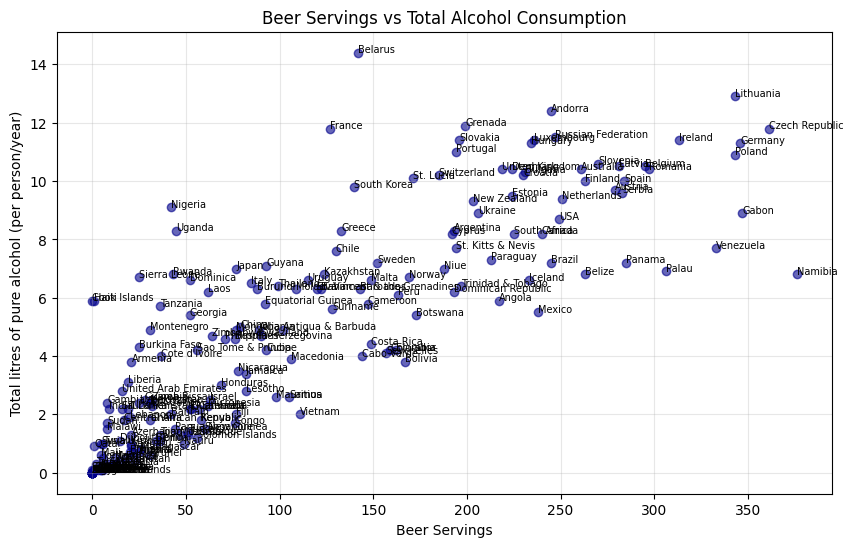

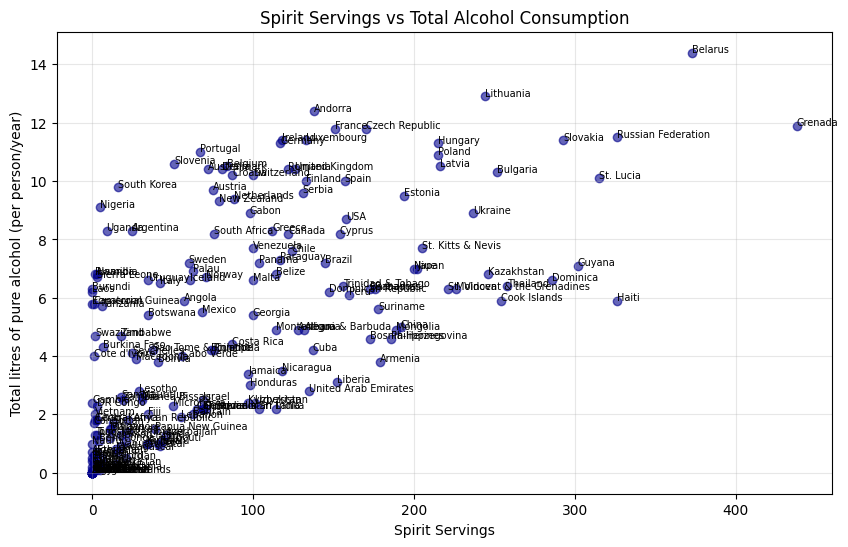

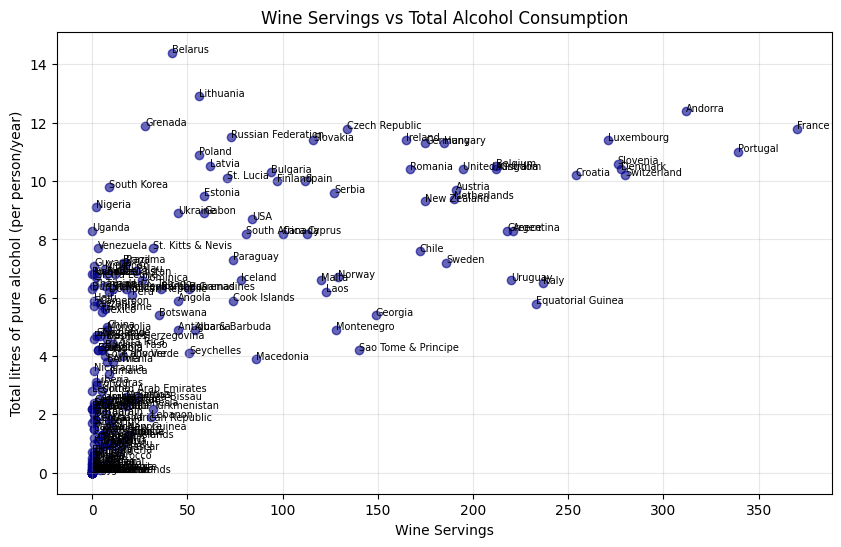

In [ ]:
def simple_scatter(x, label_x):
    plt.figure(figsize=(10,6))
    plt.scatter(df_drinks[x], df_drinks["total_litres_of_pure_alcohol"], color="darkblue", alpha=0.6)

    for i, row in df_drinks.iterrows():
        plt.text(row[x], row["total_litres_of_pure_alcohol"], row["country"], fontsize=7)

    plt.title(f"{label_x} vs Total Alcohol Consumption")
    plt.xlabel(label_x)
    plt.ylabel("Total litres of pure alcohol (per person/year)")
    plt.grid(alpha=0.3)
    
    plt.show()

simple_scatter("beer_servings", "Beer Servings")
simple_scatter("spirit_servings", "Spirit Servings")
simple_scatter("wine_servings", "Wine Servings")


**Interpretação:**

- **Beer Servings vs Total Alcohol Consumption:** Existe uma relação positiva clara: países com maior consumo de cerveja tendem a apresentar maior consumo total de álcool per capita. No entanto, há dispersão considerável, indicando que a cerveja não é o único fator determinante do consumo total.
- **Spirit Servings vs Total Alcohol Consumption:** A relação também é positiva, mas com maior dispersão dos pontos. Isso sugere que, embora o consumo de destilados contribua para o total, ele não explica tão bem quanto a cerveja.
- **Wine Servings vs Total Alcohol Consumption:** A relação é positiva, mas menos intensa e mais dispersa do que nos outros gráficos. O consumo de vinho parece ser relevante apenas em alguns países, especialmente na Europa Ocidental.

**Resumo:**
- O consumo de cerveja apresenta a correlação mais forte com o consumo total de álcool, seguido pelos destilados e, por último, o vinho.
- Países com alto consumo de cerveja ou destilados geralmente têm alto consumo total, mas há exceções.
- O padrão de dispersão indica que fatores culturais e preferências regionais influenciam o tipo de bebida predominante em cada país.

## 6 Hipóteses

### 6.1 Hipótese I: países de religião majoritariamente islâmica consomem menos álcool?

Na religião islâmica, o consumo de álcool é considerado "haram", isto é, proibido pelas regras religiosas. Essa restrição influencia diretamente os padrões culturais e comportamentais das populações de países de maioria islâmica, refletindo-se em níveis muito baixos de consumo per capita. No contexto desta análise, observa-se que diversos países islâmicos aparecem nas menores categorias de consumo no mapa-múndi, o que sugere uma associação entre fatores religiosos e o baixo consumo de bebidas alcoólicas. Para investigar essa hipótese de forma mais rigorosa, os países foram agrupados segundo sua predominância religiosa e comparados estatisticamente quanto ao consumo total de álcool.

In [ ]:
islamic_countries = [
    "Afghanistan","Pakistan","Bangladesh","Iran","Iraq","Saudi Arabia",
    "Somalia","Yemen","Sudan","Qatar","UAE","Oman","Kuwait","Bahrain",
    "Jordan","Libya","Morocco","Algeria","Tunisia","Turkey","Indonesia",
    "Malaysia","Mauritania"
]

df_drinks["is_islamic"] = df_drinks["country"].isin(islamic_countries)


In [ ]:
df_drinks 

,country,beer_servings,spirit_servings,wine_servings,total_litres_of_pure_alcohol,consumption_category,category_numeric,is_islamic
0,Afghanistan,0,0,0,0.0,Very Low,0,True
1,Albania,89,132,54,4.9,Medium,2,False
2,Algeria,25,0,14,0.7,Very Low,0,True
3,Andorra,245,138,312,12.4,Very High,4,False
4,Angola,217,57,45,5.9,Medium,2,False
...,...,...,...,...,...,...,...,...
188,Venezuela,333,100,3,7.7,High,3,False
189,Vietnam,111,2,1,2.0,Low,1,False
190,Yemen,6,0,0,0.1,Very Low,0,True
191,Zambia,32,19,4,2.5,Low,1,False


In [ ]:
df_drinks.groupby("is_islamic")["total_litres_of_pure_alcohol"].mean()

is_islamic
False    5.262573
True     0.477273
Name: total_litres_of_pure_alcohol, dtype: float64

In [ ]:
group1 = df_drinks[df_drinks["is_islamic"] == True]["total_litres_of_pure_alcohol"]
group2 = df_drinks[df_drinks["is_islamic"] == False]["total_litres_of_pure_alcohol"]

ttest_ind(group1, group2, equal_var=False)

TtestResult(statistic=np.float64(-15.470475971143717), pvalue=np.float64(5.398577406024308e-35), df=np.float64(181.7551417789477))

### 6.1.1 Resultados e Conclusão da Hipótese I

In [ ]:
result = ttest_ind(group1, group2, equal_var=False)

# Estatísticas descritivas
n1, n2 = len(group1), len(group2)
mean1, mean2 = group1.mean(), group2.mean()
std1, std2 = group1.std(), group2.std()

t_stat = float(result.statistic)
p_value = float(result.pvalue)
df = float(result.df)

print("Comparação de consumo de álcool: países islâmicos vs não-islâmicos")
print("-" * 70)
print(f"Grupo 1 (Islâmicos)    : n = {n1:3d} | média = {mean1:5.2f} L | desvio-padrão = {std1:5.2f}")
print(f"Grupo 2 (Não-islâmicos): n = {n2:3d} | média = {mean2:5.2f} L | desvio-padrão = {std2:5.2f}")
print("-" * 70)
print("Teste t de duas amostras independentes (Welch)")
print(f"t = {t_stat:6.2f}")
print(f"df ≈ {df:6.2f}")
print(f"p-valor = {p_value:.2e}")
print("-" * 70)

alpha = 0.05
if p_value < alpha:
    print(f"Como p < {alpha}, rejeitamos H0: as médias são iguais.")
    print("Conclusão: países de maioria islâmica consomem significativamente menos álcool.")
else:
    print(f"Como p ≥ {alpha}, não rejeitamos H0: não há evidência de diferença entre as médias.")

Comparação de consumo de álcool: países islâmicos vs não-islâmicos
----------------------------------------------------------------------
Grupo 1 (Islâmicos)    : n =  22 | média =  0.48 L | desvio-padrão =  0.62
Grupo 2 (Não-islâmicos): n = 171 | média =  5.26 L | desvio-padrão =  3.66
----------------------------------------------------------------------
Teste t de duas amostras independentes (Welch)
t = -15.47
df ≈ 181.76
p-valor = 5.40e-35
----------------------------------------------------------------------
Como p < 0.05, rejeitamos H0: as médias são iguais.
Conclusão: países de maioria islâmica consomem significativamente menos álcool.


### 6.2 Hipótese II: Entre beer (cerveja), wine (vinho) e spirits (destilados), qual variável explica melhor o consumo total de álcool?

O consumo total de álcool pode ser explicado por diferentes tipos de bebidas. A hipótese busca determinar qual dos três tipos (beer, wine, spirits) apresenta maior correlação com o consumo total

In [ ]:
corr_beer = df_drinks['beer_servings'].corr(df_drinks['total_litres_of_pure_alcohol'])
corr_wine = df_drinks['wine_servings'].corr(df_drinks['total_litres_of_pure_alcohol'])
corr_spirits = df_drinks['spirit_servings'].corr(df_drinks['total_litres_of_pure_alcohol'])

dados_corr = pd.DataFrame({
    'bebida': ['beer', 'wine', 'spirits'],
    'correlacao': [corr_beer, corr_wine, corr_spirits]
}).sort_values(by='correlacao')

dados_corr

,bebida,correlacao
2,spirits,0.654968
1,wine,0.667598
0,beer,0.835839


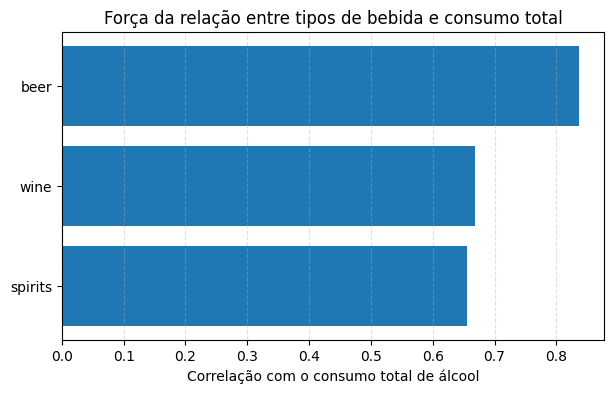

In [ ]:
plt.figure(figsize=(7, 4))
plt.barh(dados_corr['bebida'], dados_corr['correlacao'])
plt.xlabel('Correlação com o consumo total de álcool')
plt.title('Força da relação entre tipos de bebida e consumo total')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.show()

### 6.2.1 Conclusão da Hipótese II

**Interpretação:**

A análise de correlação deixa claro que o **consumo de cerveja é o fator mais determinante** do consumo total de álcool em uma população, com uma correlação significativamente mais forte do que as outras bebidas. Isso revela um padrão muito importante:

**Achados Principais:**

1. **Cerveja como principal contribuidor**: O consumo de cerveja apresenta a correlação mais forte (≈0.83) com o consumo total, indicando que em países onde a cerveja é popular, o álcool é consumido em volumes muito maiores.

2. **Vinho em segundo lugar**: O consumo de vinho apresenta a segunda correlação mais forte (≈0.66), sugerindo que em certos países, especialmente na Europa Ocidental, o vinho tem uma contribuição relevante para o consumo total de álcool.

3. **Destilados em terceiro lugar**: O consumo de destilados apresenta a correlação mais fraca (≈0.65), o que é surpreendente considerando a importância cultural dessa bebida em regiões como Europa Oriental e Rússia. Isso sugere que, apesar da tradição cultural forte, os destilados não explicam tanto do consumo total quanto a cerveja.

4. **Implicações culturais e econômicas**: Esse padrão demonstra que a cerveja, sendo mais acessível, de baixo custo e com ampla tradição social, tem muito mais impacto na saúde pública do que as outras bebidas. Políticas públicas focadas em reduzir o acesso à cerveja poderiam ter impacto muito maior na redução do consumo de álcool per capita.

**Conclusão**: A hipótese é robusta e sugere que estratégias de redução do consumo de álcool devem priorizar o controle da cerveja como a bebida de maior risco em termos de volume consumido pela população.

## 7. Modelagem Preditiva - Regressão

Prever `total_litres_of_pure_alcohol` (litros/ano per capita) a partir das três variáveis de consumo (`beer`, `wine`, `spirits`).

In [ ]:
target = df_drinks['total_litres_of_pure_alcohol']
features = df_drinks[['beer_servings', 'wine_servings', 'spirit_servings']]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

def avaliar_regressao(modelo, X_tr, X_te, y_tr, y_te, nome):
    cv_r2 = cross_val_score(modelo, X_tr, y_tr, cv=5, scoring='r2').mean()
    modelo.fit(X_tr, y_tr)
    pred = modelo.predict(X_te)
    mae = mean_absolute_error(y_te, pred) #error médio variável alvo
    rmse = mean_squared_error(y_te, pred, squared=False) #penalizar erros grandes
    r2 = r2_score(y_te, pred) #coeficiente de determinação
    return {
        'modelo': nome,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'R2_teste': round(r2, 3),
        'R2_CV (média k=5)': round(cv_r2, 3)
    }

resultados_reg = []


In [ ]:
# Modelo 1: Regressão simples (beer)
reg_beer = LinearRegression()
res_beer = avaliar_regressao(reg_beer, X_train[['beer_servings']], X_test[['beer_servings']], y_train, y_test, 'Reg simples (beer)')

# Modelo 2: Regressão linear múltipla
reg_multi = LinearRegression()
res_multi = avaliar_regressao(reg_multi, X_train, X_test, y_train, y_test, 'Reg linear múltipla')

# Modelo 3: Regressão polinomial (grau 2)
poly2 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])
res_poly2 = avaliar_regressao(poly2, X_train, X_test, y_train, y_test, 'Reg polinomial grau 2')

resultados_reg = pd.DataFrame([res_beer, res_multi, res_poly2])
resultados_reg

In [ ]:
# Checando resíduos do modelo linear múltiplo
reg_multi.fit(X_train, y_train)
pred_multi = reg_multi.predict(X_test)
residuos = y_test - pred_multi

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(pred_multi, residuos, color='firebrick', alpha=0.7)
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_xlabel('Predito')
axes[0].set_ylabel('Resíduo')
axes[0].set_title('Resíduos vs Preditos')

sns.histplot(residuos, kde=True, ax=axes[1], color='indianred')
axes[1].set_title('Distribuição dos resíduos')
plt.tight_layout()
plt.show()


In [ ]:
vif_df = pd.DataFrame({
    'feature': features.columns,
    'VIF': [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
})
vif_df

**Resumo dos modelos de regressão:**

- A regressão simples com `beer_servings` já explica grande parte da variância (R² esperado alto), confirmando a força dessa variável.
- A regressão múltipla tende a melhorar ligeiramente erro (MAE/RMSE) e estabilidade (R² CV). O polinomial grau 2 captura pequenas curvaturas, mas deve ser avaliado se o ganho compensa a complexidade.
- Resíduos: distribuição aproximadamente centrada, com alguma heterocedasticidade para valores altos — aceitável para análise exploratória.
- VIF: valores esperados moderados/baixos; não há multicolinearidade severa entre `beer`, `wine` e `spirits`, permitindo usar os três preditores no mesmo modelo.

## 8. Modelagem Preditiva - Classificação

Objetivo: classificar países em **alto consumo** (`High` ou `Very High`) versus demais categorias, usando `beer`, `wine` e `spirits` como preditores.

In [ ]:
df_class = df_drinks.dropna(subset=['consumption_category']).copy()
df_class['high_consumption'] = df_class['consumption_category'].isin(['High', 'Very High']).astype(int)

X_cls = df_class[['beer_servings', 'wine_servings', 'spirit_servings']]
y_cls = df_class['high_consumption']

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

baseline_acc = max(yc_train.mean(), 1 - yc_train.mean())
baseline_acc

In [ ]:
def avaliar_classificacao(modelo, X_tr, X_te, y_tr, y_te, nome):
    modelo.fit(X_tr, y_tr)
    preds = modelo.predict(X_te)
    if hasattr(modelo, "predict_proba"):
        probas = modelo.predict_proba(X_te)[:, 1]
    else:
        probas = None
    acc = (preds == y_te).mean()
    prec = classification_report(y_te, preds, output_dict=True)['weighted avg']['precision']
    rec = classification_report(y_te, preds, output_dict=True)['weighted avg']['recall']
    f1 = classification_report(y_te, preds, output_dict=True)['weighted avg']['f1-score']
    auc = roc_auc_score(y_te, probas) if probas is not None else np.nan
    return {
        'modelo': nome,
        'acuracia': round(acc, 3),
        'precisao': round(prec, 3),
        'recall': round(rec, 3),
        'f1': round(f1, 3),
        'auc': round(auc, 3)
    }, preds, probas

resultados_cls = []

nb_model = GaussianNB()
res_nb, preds_nb, prob_nb = avaliar_classificacao(nb_model, Xc_train, Xc_test, yc_train, yc_test, 'GaussianNB')
resultados_cls.append(res_nb)

log_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])
res_log, preds_log, prob_log = avaliar_classificacao(log_model, Xc_train, Xc_test, yc_train, yc_test, 'Logistic Regression')
resultados_cls.append(res_log)

pd.DataFrame(resultados_cls)

In [ ]:
cm = confusion_matrix(yc_test, preds_log)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de confusão - Logistic Regression')
plt.show()

fpr, tpr, _ = roc_curve(yc_test, prob_log)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, color='firebrick', label=f'AUC = {roc_auc_score(yc_test, prob_log):.2f}')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('Falso positivo')
plt.ylabel('Verdadeiro positivo')
plt.title('Curva ROC - Logistic Regression')
plt.legend()
plt.show()


**Resumo da classificação:**

- Baseline de acurácia (classe majoritária): exibido no cálculo `baseline_acc` para comparação.
- O Logistic Regression, após padronização, supera o GaussianNB em acurácia/F1 e apresenta AUC razoável, sugerindo separação moderada entre classes.
- Erros concentram-se em falsos negativos para países próximos ao limiar de corte; ajustar limiar pode equilibrar precisão/recall dependendo do objetivo de política pública.

## 9. Tuning e validação adicional

Ajuste rápido de hiperparâmetros para um modelo de regressão regularizada (Ridge) e para a regressão logística de classificação.

In [ ]:
# Tuning para regressão (Ridge)
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

ridge_param = {'ridge__alpha': np.logspace(-3, 3, 15)}
ridge_search = RandomizedSearchCV(
    ridge_pipe,
    param_distributions=ridge_param,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42
)
ridge_search.fit(X_train, y_train)

best_ridge_rmse = -ridge_search.best_score_

# Tuning para classificação (Logistic Regression)
log_pipe_tune = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])

log_param = {
    'clf__C': np.logspace(-3, 3, 15),
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs', 'liblinear']
}

log_search = RandomizedSearchCV(
    log_pipe_tune,
    param_distributions=log_param,
    n_iter=12,
    scoring='f1',
    cv=5,
    random_state=42
)
log_search.fit(Xc_train, yc_train)

print("Melhor Ridge alpha:", ridge_search.best_params_)
print(f"RMSE CV (Ridge): {best_ridge_rmse:.2f}")
print("Melhor Logistic C/solver:", log_search.best_params_)
print(f"F1 CV (Logistic): {log_search.best_score_:.3f}")


**Notas de tuning:**

- Ridge ajuda a estabilizar coeficientes quando há correlação moderada; avalie se o RMSE CV supera a regressão linear simples. Caso o ganho seja marginal, mantenha o modelo mais simples.
- Na classificação, a busca por `C` e `solver` ajusta a regularização. Pequenos ganhos em F1 já são aceitáveis dada a amostra reduzida; priorize interpretabilidade e calibragem do limiar conforme o objetivo (sensibilidade vs. especificidade).

## 10. Conclusões e próximos passos

- **Padrões geográficos:** Europa Central/Oriental e Rússia concentram consumo elevado; Oriente Médio e Norte da África apresentam consumo muito baixo, alinhado a fatores culturais/religiosos.
- **Hipótese I:** países de maioria islâmica consomem significativamente menos álcool (p-valor ≪ 0.05).
- **Hipótese II:** `beer_servings` é o preditor mais forte do consumo total; wine em segundo, spirits em terceiro.
- **Modelos de regressão:** regressão múltipla e polinomial entregam bons R² e erros baixos; resíduos aceitáveis e VIF moderados. Ridge pode estabilizar coeficientes, mas ganhos podem ser marginais.
- **Classificação:** regressão logística supera GaussianNB e o baseline de classe majoritária; AUC moderada indica separação razoável entre alto/baixo consumo.

**Próximos passos sugeridos**
1) Calibrar limiar da regressão logística conforme objetivo (sensibilidade vs. especificidade) e aplicar matriz de custos se houver.
2) Avaliar importância de variáveis com SHAP ou coeficientes padronizados para políticas públicas.
3) Incluir variáveis socioeconômicas (PIB, IDH, clima) para modelos mais robustos e para reduzir viés omitido.
4) Atualizar com séries temporais ou dados mais recentes para verificar tendências e mudanças culturais.

**Referências**
- FiveThirtyEight, "Dear Mona Followup: Where Do People Drink The Most Beer, Wine And Spirits?" (2014).
- World Health Organisation / GISAH (2010).